# Testing DEMV on _Contraceptive Method Choice_ dataset

Source: [https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)

- Label: `contr_use`
- Unprivileged group: `wife_religion=1`
- Positive label: `2 (long-term)`

In [20]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [21]:
data = pd.read_csv('data/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [22]:
data.groupby(['wife_religion'])['contr_use'].value_counts()

wife_religion  contr_use
0              2             76
               1             75
               3             69
1              1            554
               3            442
               2            257
Name: contr_use, dtype: int64

In [23]:
label = 'contr_use'
sensitive_features = ['wife_religion']
unpriv_group = {'wife_religion': 1}
positive_label= 2

In [24]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased dataset

In [25]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [26]:
print_metrics(bias_metrics)

Statistical parity:  -0.316  +-  0.084
Disparate impact:  0.284  +-  0.087
Zero one loss:  0.15  +-  0.084
F1 score:  0.517  +-  0.039
Accuracy score:  0.521  +-  0.038


## DEMV dataset

In [27]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [28]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [29]:
print_metrics(demv_metrics)

Statistical parity:  -0.02  +-  0.079
Disparate impact:  0.668  +-  0.233
Zero one loss:  0.106  +-  0.055
F1 score:  0.506  +-  0.044
Accuracy score:  0.515  +-  0.042


## Exponentiated Gradient

In [30]:
constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
exp = ExponentiatedGradient(pipeline, constr, sample_weight_name="classifier__sample_weight")

In [31]:
model, exp_metrics = cross_val(exp, data.copy(), label, unpriv_group, sensitive_features, exp=True, positive_label=positive_label)

Execution time: 14s

In [32]:
print_metrics(exp_metrics)

Statistical parity:  -0.273  +-  0.064
Disparate impact:  0.314  +-  0.096
Zero one loss:  0.131  +-  0.08
F1 score:  0.497  +-  0.043
Accuracy score:  0.503  +-  0.038


## DEMV Evaluation

In [33]:
eval_data = data.copy()

In [34]:
demv.get_iters()

22

In [35]:
metrics = eval_demv(3, demv.get_iters(), eval_data, pipeline, label, unpriv_group, sensitive_features, positive_label)

Execution time: ~6min

In [36]:
df = prepareplots(metrics,'cmcSinglevar')

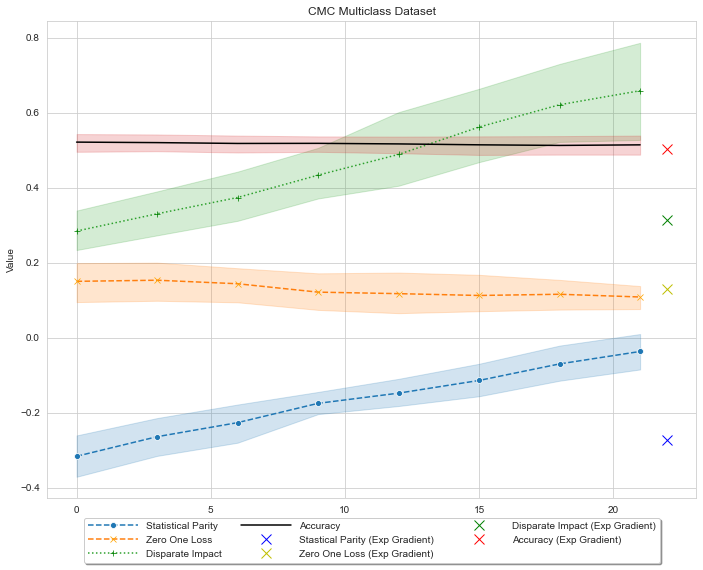

In [37]:
points = preparepoints(exp_metrics, demv.get_iters())
plot_metrics_curves(df, points, title='CMC Multiclass Dataset')

In [38]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1473
Unprivileged group size: 1253
Percentage of unprivileged group: 85.06449422946368
Number of iterations: 22
